In [75]:
import pandas as pd
df = pd.read_csv("../Data_120294_2023-03-29.csv")


/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_73032/5298821.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data_120294_2023-03-29.csv")


In [76]:
desired_columns = ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'init_creat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr', 'tx_date', 'init_date']

df = df[desired_columns]

In [ ]:
#Print all values in ethcat
print(df['ethcat'].unique())

#Print number of rows with value 6 in ethcat

#Print number of rows with value 6 in ethcat before replacing values
print(f'Number of rows with value 6 in ethcat before replacing values: {len(df[df["ethcat"] == 6])}')

#1=1 (White), 2=2 (Black), 4=4 (Hispanic), 5=5 (Asian),6=6 (tidigare Amer Ind/Alaskan, kodas nu om till Other) 7=6 (tidigare Native Hawaiian, nu Other) 9=6 (tidigare Multiracial, nu Other) 
#Replace all values except 1,2,4 and 5, with 6 in ethcat
df['ethcat'] = df['ethcat'].replace([7,9,998], 6)

#Print number of rows with value 6 in ethcat after replacing values
print(f'Number of rows with value 6 in ethcat after replacing values: {len(df[df["ethcat"] == 6])}')

[Text(0.5, 0, 'Percentage of missing values'),
 Text(0, 0.5, 'Number of columns')]

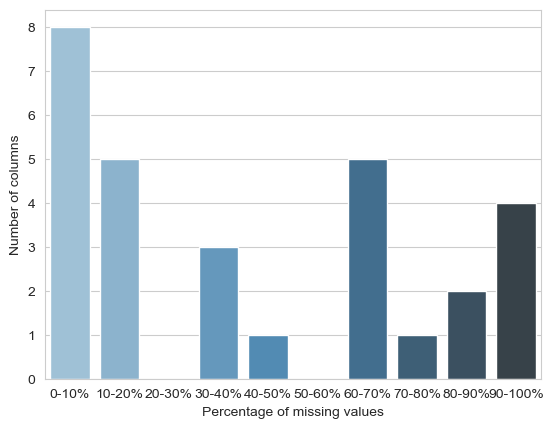

In [77]:
import seaborn as sns

missing_pct = df.isnull().sum() / len(df.index) * 100
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{i}-{j}%' for i, j in zip(bin_edges[:-1], bin_edges[1:])]

# Bin the columns according to their missing value percentage
bins = pd.cut(missing_pct, bins=bin_edges, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = bins.value_counts().sort_index()

# Create a bar plot of the bin counts
sns.set_style("whitegrid")
ax = sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")
ax.set(xlabel="Percentage of missing values", ylabel="Number of columns")

In [78]:
# Remove rows with no transplant date
pre_len = len(df.index)
df = df[df['tx_date'].notna()]
post_len = len(df.index)
print(f"Filtered to only transplanted patients: {post_len}/{pre_len} ({post_len/pre_len*100:.2f}% remaining)")

# Compute the time to transplant (waitlist time -> wl_time)
df['wl_time'] = (pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days
df = df.drop(columns=['tx_date', 'init_date'])
print(f"Mean waitlist time: {df['wl_time'].mean():.2f} days")


Filtered to only transplanted patients: 77410/120264 (64.37% remaining)
Mean waitlist time: 192.53 days


In [79]:
# Remove columns where all values are missing
pre_len = len(df.columns)
df = df.dropna(axis=1, how='all')
post_len = len(df.columns)
print(f"Removed columns with all missing values: {pre_len-post_len}/{pre_len} ({(pre_len-post_len)/pre_len*100:.2f}% removed)")

# Remove columns where there is no variance
pre_len = len(df.columns)
df = df.loc[:, df.nunique() != 1]
post_len = len(df.columns)
print(f"Removed columns with no variance: {pre_len-post_len}/{pre_len} ({(pre_len-post_len)/pre_len*100:.2f}% removed)")


Removed columns with all missing values: 1/37 (2.70% removed)
Removed columns with no variance: 2/36 (5.56% removed)


In [80]:
# We need to find the categorical columns, use OrdinalEncoder to encode them first.
# Once encoded, we will impute the mising values using MissForest imputation. We will then revert the encoding back to the original categorical values and use OneHotEncoder to encode them.
from sklearn.preprocessing import OrdinalEncoder

# Find the categorical columns using nunique
categorical_columns = df.nunique()[df.nunique() < 10].index.tolist()
categorical_column_indexes = [df.columns.get_loc(c) for c in categorical_columns if c in df]
# Print the number of of categorical columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")

ordinal_encoder = OrdinalEncoder()

# Encode the categorical columns
df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])


Categorical columns: ['tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'ethnicity', 'ventilator_tcr', 'work_income_tcr', 'academic_level_tcr']


In [ ]:
# Print the total number of missing values in categorical colums before replacing missing values with "missing"
print(f"Total number of missing values in categorical columns before replacing missing values with 'missing': {df[categorical_columns].isnull().sum().sum()}")

#For all categorical columns, replace missing values with the string "missing"
for col in categorical_columns:
    df[col] = df[col].fillna("missing")

# Print the total number of missing values in categorical colums after replacing missing values with "missing"
print(f"Total number of missing values in categorical columns after replacing missing values with 'missing': {df[categorical_columns].isnull().sum().sum()}")


In [ ]:
#Split the dataframe into two dataframes, one for categorical columns and one for numerical columns
df_categorical = df[categorical_columns] 
df_numerical = df.drop(columns=categorical_columns)

#For each column in df_numberical, add another columns with the same name but with the suffix "_missing" that contains 1 if the value is missing and 0 if the value is not missing
for col in df_numerical.columns:
    df_numerical[col + "_missing"] = df_numerical[col].isnull().astype(int)

#Concate df_categorical and df_numerical to one dataframe
df = pd.concat([df_categorical, df_numerical], axis=1)

df_sample = df[['most_rcnt_creat', 'most_rcnt_creat_missing']]

df_sample.sample(15)

In [81]:
# Impute the missing values using MissForest
from missingpy import MissForest
imputer = MissForest()
df = pd.DataFrame(imputer.fit_transform(df, cat_vars=categorical_column_indexes), columns=df.columns)


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/missingpy/missforest.py:475: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  col_modes = mode(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explici

Iteration: 0


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 1


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 2


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 3


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 4


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 5


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 6


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 7


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 8


/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/envs/edap01/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto

Iteration: 9


In [82]:
# Revert the encoding
df[categorical_columns] = ordinal_encoder.inverse_transform(df[categorical_columns])


In [83]:
# One hot encode the categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_73032/945301898.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_73032/945301898.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_73032/945301898.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_73032/945301898.py:2: FutureWarning: In a future version, the Index constructor wil

In [84]:
from datetime import datetime

datetime_str = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
df.to_csv(f"../{datetime_str}_imputed.csv", index=False)
